In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

Using TensorFlow backend.


In [2]:
!git clone https://github.com/hromi/SMILEsmileD.git
!ls

fatal: destination path 'SMILEsmileD' already exists and is not an empty directory.
model.hdf5  sample_data  SMILEsmileD


In [0]:
args = {'dataset': "/content/SMILEsmileD/SMILEs"}
data = []
labels = []
for imagePath in sorted(list(paths.list_images(args['dataset']))):
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = imutils.resize(image, width=28)
  image = img_to_array(image)
  data.append(image)
  label = imagePath.split(os.path.sep)[-3]
  label = "smiling" if label == 'positives' else 'not_smiling'
  labels.append(label)

In [0]:
data = np.array(data, dtype='float') / 255.0
labels = np.array(labels)
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [5]:
model = Sequential()
model.add(Conv2D(20,(5, 5), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(50,(5, 5), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))

model.add(Dense(2))
model.add(Activation('softmax'))

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=0.20, 
                                                  stratify=labels,
                                                  random_state=42)

print('[INFO] compiling model...')
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
print('[INFO] training network...')
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              class_weight=classWeight, batch_size=64, epochs=15,
              verbose=1)


[INFO] compiling model...


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[INFO] training network...



Train on 10532 samples, validate on 2633 samples
Epoch 1/15





10532/10532 [==============================] - 3s 322us/step - loss: 0.4153 - acc: 0.8130 - val_loss: 0.3166 - val_acc: 0.8671
Epoch 2/15
10532/10532 [==============================] - 1s 90us/step - loss: 0.2767 - acc: 0.8882 - val_loss: 0.2753 - val_acc: 0.8861
Epoch 3/15
10532/10532 [==============================] - 1s 89us/step - loss: 0.2487 - acc: 0.9012 - val_loss: 0.2558 - val_acc: 0.8971
Epoch 4/15
10532/10532 [==============================] - 1s 87us/step - loss: 0.2323 - acc: 0.9069 - val_loss: 0.2634 - val_acc: 0.8918
Epoch 5/15
10532/10532 [==============================] - 1s 85us/step - loss: 0.2226 - acc: 0.9141 - val_loss: 0.2406 - val_acc: 0.9032
Epoch 6/15
10532/10532 [==============================] - 1s 85us/step - loss: 0.2114 - acc: 0.9180 - val_lo

In [7]:
print('[INFO] evaluating network...')
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
      predictions.argmax(axis=1), target_names=le.classes_))
print('[INFO] serializeinf network...')
model.save('/content/model.hdf5')

[INFO] evaluating network...
              precision    recall  f1-score   support

 not_smiling       0.96      0.88      0.92      1895
     smiling       0.75      0.90      0.81       738

    accuracy                           0.89      2633
   macro avg       0.85      0.89      0.87      2633
weighted avg       0.90      0.89      0.89      2633

[INFO] serializeinf network...


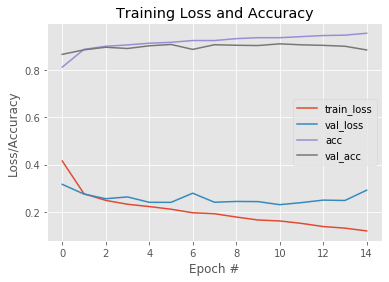

In [8]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["acc"], label="acc") 
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc") 
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()